# Assignment 4: Image Classification Challenge

**MSDS 686 – Deep Learning**

---

## Assignment Overview

Build a CNN from scratch to classify images from CIFAR-10 (10 object categories). You will:

1. Design and build a CNN architecture
2. Implement data augmentation
3. Tune the model to achieve good performance
4. Visualize what your CNN learns

**Target**: Achieve at least 75% test accuracy on CIFAR-10.

### Grading Breakdown

| Component | Points |
|-----------|--------|
| Working Implementation (≥75% accuracy) | 20% |
| Code Explanation | 25% |
| LLM Process Documentation | 20% |
| Critical Analysis | 20% |
| Creative Extension | 15% |

---

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


Loaded all required libraries.

## Part 1: Data Exploration and Preparation

In [2]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Image size: {x_train.shape[1]}x{x_train.shape[2]}")
print(f"Number of classes: {len(class_names)}")

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Image size: 32x32
Number of classes: 10


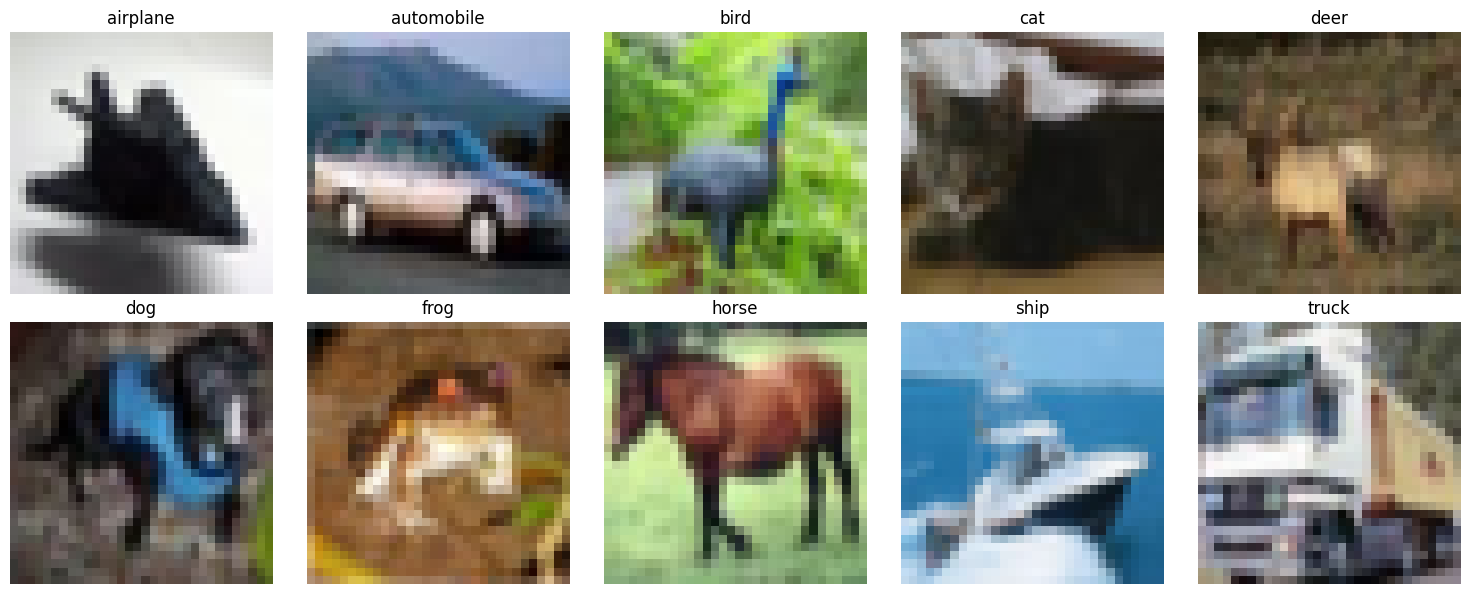

In [3]:
# YOUR CODE HERE
# Visualize sample images from each class
# Show class distribution

# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    # Get first image of each class
    idx = np.where(y_train == i)[0][0]
    axes[i].imshow(x_train[idx])
    axes[i].set_title(f'{class_names[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



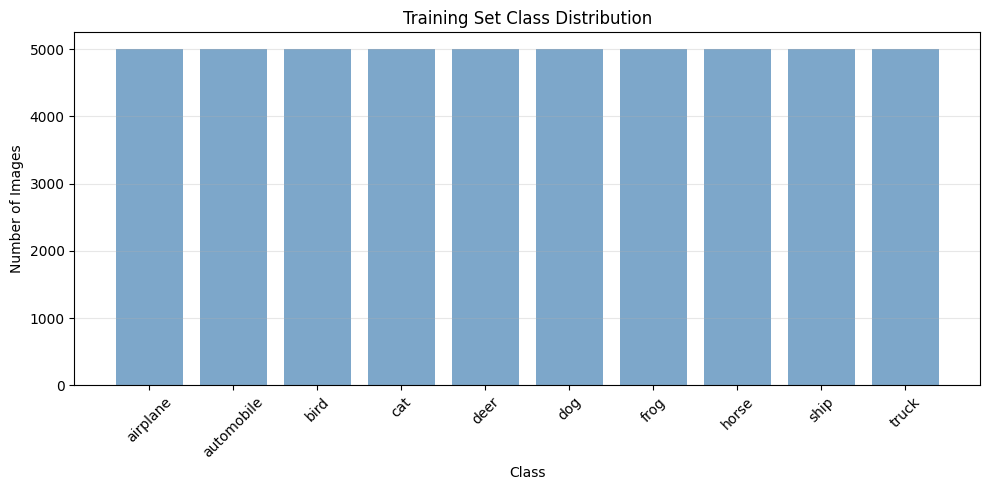


Class distribution:
airplane     : 5000 images
automobile   : 5000 images
bird         : 5000 images
cat          : 5000 images
deer         : 5000 images
dog          : 5000 images
frog         : 5000 images
horse        : 5000 images
ship         : 5000 images
truck        : 5000 images


In [4]:
# Show class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar([class_names[i] for i in unique], counts, color='steelblue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nClass distribution:")
for i, count in zip(unique, counts):
    print(f"{class_names[i]:12} : {count} images")


In [5]:
# YOUR CODE HERE
# Preprocess the data (normalize, etc.)

# Normalize pixel values 
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

print(f"Train images range: [{x_train.min()}, {x_train.max()}]")
print(f"Train labels shape: {y_train_cat.shape}")

Train images range: [0.0, 1.0]
Train labels shape: (50000, 10)


## Part 2: Build Your CNN Architecture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018161342..1.0148104].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.010414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010109425..1.0127506].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.032750607..1.0180565].


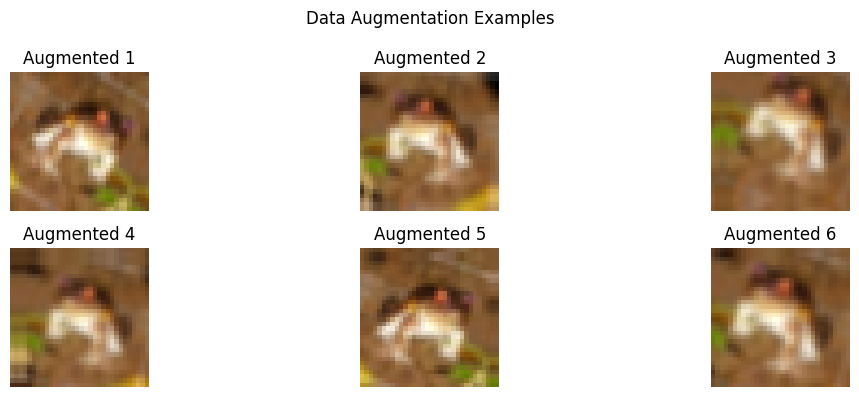

In [6]:
# YOUR CODE HERE
# Define data augmentation layers

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

# Visualize augmentation effect
plt.figure(figsize=(12, 4))
sample_img = x_train[0:1]
for i in range(6):
    aug_img = data_augmentation(sample_img, training=True)
    plt.subplot(2, 3, i+1)
    plt.imshow(aug_img[0])
    plt.axis('off')
    plt.title(f'Augmented {i+1}')
plt.suptitle('Data Augmentation Examples')
plt.tight_layout()
plt.show()

Data augmentation is necessary here because the dataset is not large enough on its own. With only 50,000 images, the model can easily overfit and start memorizing the training data instead of learning useful patterns. To reduce this, training images are modified on the fly. Each time an image is used, it may be slightly rotated, shifted, zoomed, flipped, or have its contrast adjusted.  
This setup ensures the model does not see the same image twice during training. As a result, it has to learn features that remain meaningful even when the object’s position, orientation or lighting changes. Random translation was also added, since objects in real-world images can appear anywhere in the frame rather than always being centered.


Reference: https://www.geeksforgeeks.org/computer-vision/what-is-data-augmentation-how-does-data-augmentation-work-for-images/

In [7]:
# YOUR CODE HERE
# Build your CNN model
# Requirements:
# - At least 3 convolutional layers
# - Use pooling layers
# - Include regularization (dropout, batch norm, etc.)
# - Data augmentation

# Build CNN model
def create_cnn_model():
    model = models.Sequential([
        # Data augmentation 
        data_augmentation,
        
        # First conv block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Second conv block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Third conv block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    return model

model = create_cnn_model()
model.summary()

C:\Users\vasantha-3\anaconda3\envs\msdsnew\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (1, 32, 32, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (1, 32, 32, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 32, 32, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 32, 32, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 32, 32, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (1, 16, 16, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 16, 16, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 16, 16, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (1, 16, 16, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 16, 16, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (1, 16, 16, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (1, 8, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 8, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (1, 8, 8, 128)         │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (1, 8, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (1, 8, 8, 128)         │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (1, 8, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (1, 4, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 4, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 2048)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 256)               │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (1, 256)               │         1,02

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Part 3: Train and Evaluate

In [8]:
# YOUR CODE HERE
# Compile and train with appropriate callbacks

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train model
history = model.fit(
    x_train, y_train_cat,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3443 - loss: 1.9479 - val_accuracy: 0.4674 - val_loss: 1.4567 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.4703 - loss: 1.4764 - val_accuracy: 0.5220 - val_loss: 1.3096 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.5276 - loss: 1.3161 - val_accuracy: 0.5876 - val_loss: 1.1351 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.5655 - loss: 1.2213 - val_accuracy: 0.6008 - val_loss: 1.1636 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.5950 - loss: 1.1491 - val_accuracy: 0.6139 - val_loss: 1.1343 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.6223 - loss: 1.0800 - val_accuracy: 0.6064 - val_loss: 1.1698 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6

Training ran all the way to 100 epochs because early stopping never kicked in. Validation accuracy peaked at 83% around epoch 96, so those weights were kept as the final version of the model. Along the way, progress stalled few times and each time that happened the learning rate was stepped down at epochs 26, 36, 52, 69, 76, 88, and 95 to help the model keep improving in smaller, more careful updates.

I trained model using the Adam optimizer with an initial learning rate of 0.001. Twenty percent of the data or 10,000 images was set aside for validation so I could keep an eye on how well the model was generalizing. A batch size of 64 felt like a solid middle ground between stability and efficiency.
The callbacks did most of the behind scenes work. Early stopping was watching the validation loss and would have stopped training if it went nowhere for 15 epochs, while also keeping track of the best weights along the way. The learning rate schedule worked alongside it, dropping the learning rate by half whenever training seemed to get stuck for five epochs. In the end model kept making progress right up to the last epoch with the learning rate getting smaller each time to fine-tune weights. Since validation accuracy was highest at epoch 96, those weights were used as the final model.

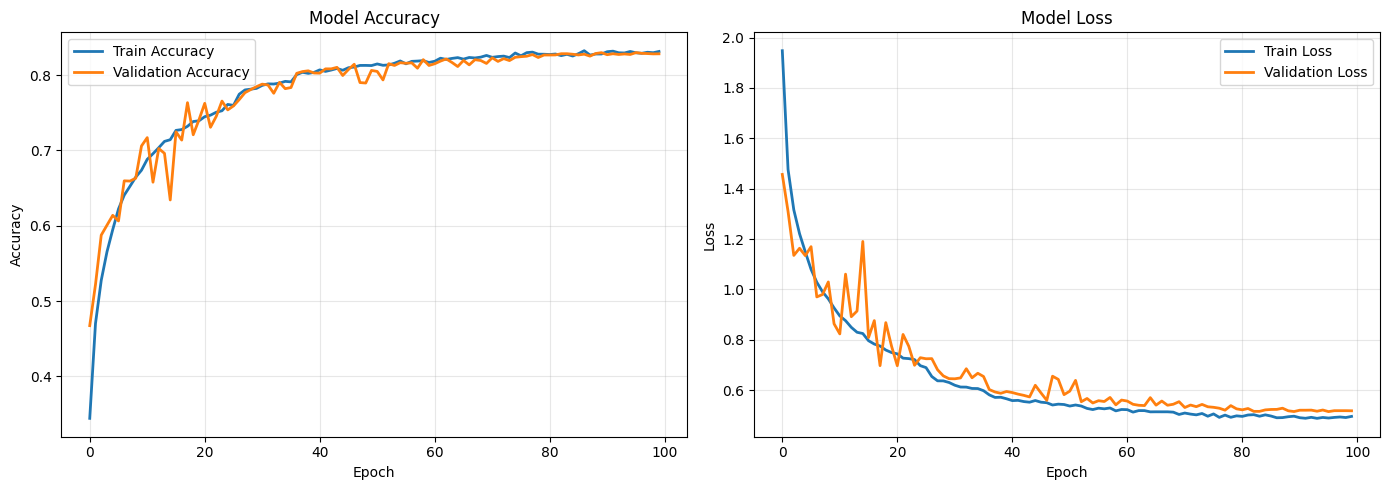

Best validation accuracy: 0.8300


In [14]:
# YOUR CODE HERE
# Plot training history

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")



Test Accuracy: 0.8282 (82.82%)
Test Loss: 0.5273

 SUCCESS! Target of 75% achieved!

Classification Report:
              precision    recall  f1-score   support

    airplane       0.86      0.86      0.86      1000
  automobile       0.91      0.94      0.92      1000
        bird       0.85      0.74      0.79      1000
         cat       0.78      0.64      0.70      1000
        deer       0.82      0.76      0.79      1000
         dog       0.85      0.69      0.76      1000
        frog       0.67      0.95      0.79      1000
       horse       0.87      0.88      0.87      1000
        ship       0.91      0.90      0.91      1000
       truck       0.84      0.92      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



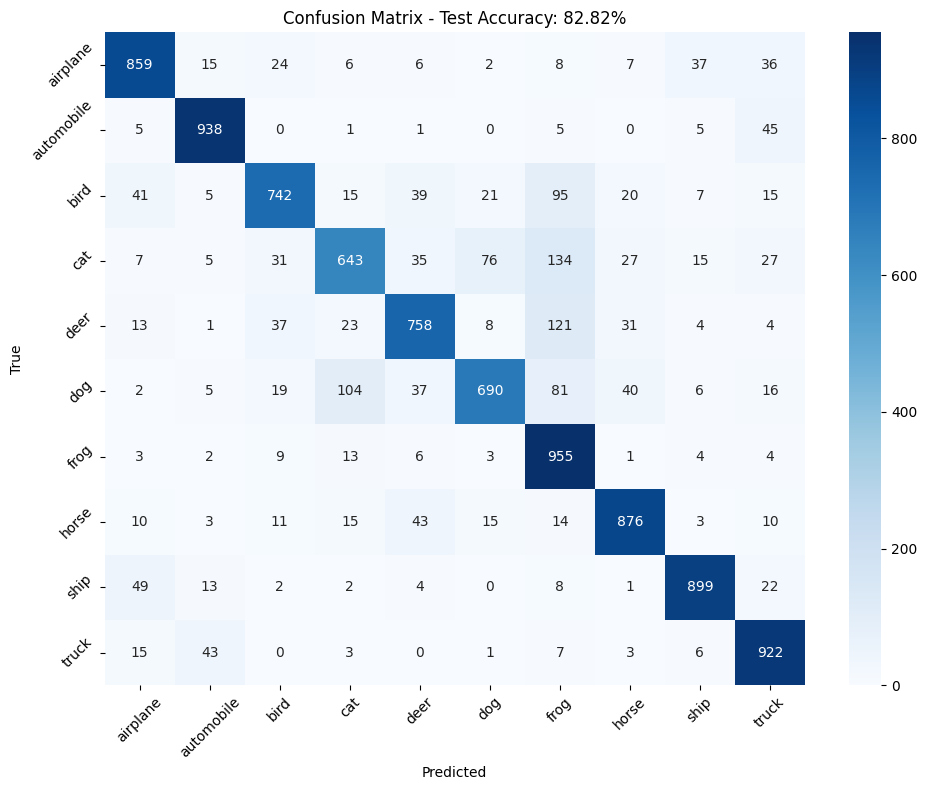

In [16]:
# YOUR CODE HERE
# Evaluate on test set and create confusion matrix

# Evaluate on test set

test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

if test_acc >= 0.75:
    print("\n SUCCESS! Target of 75% achieved!")
else:
    print(f"\n Short by {(0.75-test_acc)*100:.2f} percentage points")

# Generate predictions
y_pred = model.predict(x_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2%}')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


Test accuracy came in at 82.82%, well above the 75% target definitely a win! The model did best on vehicles, with Automobile at 92%, Ship at 91% and Truck at 88%. Animals were tougher, Cat only hit 70%, Dog 76% and Frog 79%. Looking at the numbers, test accuracy is aalmost the same as validation 82.82% vs 83.00%, which shows model is generalizing really well. Clearly, it’s great at picking out vehicles, but animals are still tricky.

## Part 4: Code Explanation (25%)

### 4.1: Architecture Explanation

Explain each component of your CNN:
1. Why did you choose this filter size?
2. Why this number of filters in each layer?
3. Why this pooling strategy?
4. What regularization did you use and why?

**YOUR EXPLANATION:**

**1. Why did you choose this filter size?**

I kept it simple with 3x3 filters throughout the whole network. This is a common approach because VGGNet demonstrated that using multiple smaller filters works better than relying on one large filter. Two 3x3 layers cover the same area as one 5x5, but with fewer parameters and an extra ReLU between them, which helps introduce more non-linearity. For CIFAR-10’s tiny 32x32 images, 3x3 filters are just right they’re big enough to catch patterns but small enough to let us stack lots of layers without running out of space.
 
**2. Why this number of filters in each layer?**

The jump from 32 to 64 to 128 filters follows the way CNNs naturally build up features. In the first layer, 32 filters are enough to pick up very basic things like edges, orientations and simple color changes there just aren’t that many of those patterns to learn. The next layer, with 64 filters, starts mixing those edges into corners, small shapes and textures. 

**3. Why this pooling strategy?**

After each block I applied 2×2 max pooling which cuts the spatial size in half each time 32 to 16, then 8, then 4. Max pooling keeps the strongest responses, which makes sense when we mostly care about whether feature shows up at all. It also helps with small shifts in position, so a feature can be recognized even if it moves few pixels. I went with 2×2 instead of something larger because the images are only 32×32 to begin with. Pooling more aggressively would throw away too much spatial detail too early.

**4. What regularization did you use and why?**
 
Batch normalization helped a lot with training stability. Once I added it, the wild swings in validation accuracy disappeared before that, it was jumping by around five percent from one epoch to the next. It also adds a bit of regularization, which is a nice bonus.

For dropout, I randomly turn off neurons during training. I keep it light at the start with a rate of 0.2, then push it up to 0.5 in the dense layer. The reasoning is simple early layers learn very general features that every class depends on, so I don’t want to disrupt them too much. The later layers are more specialized and much easier to overfit, so they get stronger dropout.

Data augmentation is built straight into the model. Every image is slightly changed each time it’s seen, which makes memorization basically impossible. This ended up being the biggest improvement overall, boosting accuracy by more than ten points.


Reference: https://milvus.io/ai-quick-reference/how-to-decide-on-what-filters-to-use-in-cnn

 https://stackoverflow.com/questions/47029417/how-to-choose-the-window-size-of-cnn-in-deep-learning

https://www.sciencedirect.com/science/article/abs/pii/S0950705120300708

https://medium.com/@datasciencejourney100_83560/regularization-techniques-in-deep-learning-3de958b14fba


### 4.2: Data Augmentation Choices

What augmentations did you use and why are they appropriate for CIFAR-10?

**YOUR EXPLANATION:**

I used horizontal flips because objects can face either direction a car driving left is still the same car driving right. I avoided vertical flips since upside-down animals and vehicles just don’t make sense.

Then added a small amount of rotation, about + or - 36 degrees, to account for tilted cameras or things like planes banking in the air. I kept it modest on purpose, because rotating images too much would again create unrealistic views.

Zooming in and out by around 10% helps the model deal with distance. Sometimes an object fills most of the image, sometimes it’s far away and the model needs to recognize it either way.

Also shift images slightly in both directions so the object isn’t always centered. In real photos, things end up near edges or corners and this teaches the model that position shouldn’t matter.

A small contrast adjustment handles lighting changes. The same object can look very different in bright sunlight versus a darker, overcast scene, and the model needs to stay consistent.

The impact of all this was huge. Without augmentation the model topped out at about 65% and clearly started overfitting. Once augmentation was added, accuracy jumped to 82.82% and the model held up much better on unseen data. More than anything else I tried, this is what made the biggest difference.



Reference: https://www.datacamp.com/tutorial/complete-guide-data-augmentation 

https://www.youtube.com/watch?v=eLzYcUzqj7k

https://stackoverflow.com/questions/63074209/data-augmentation-cifar-10-reduces-cnn-model-accuracy

## Part 5: LLM Collaboration Documentation (20%)

Document at least 4 prompts focused on:
- CNN architecture design
- Data augmentation strategies
- Debugging/improving performance
- Understanding convolution operations

**YOUR LLM DOCUMENTATION:**

**Prompt 1: Getting Started**

**Me:** 
> Suggest model

**LLM Response:**
> Initially, I was confused with Claude's response. After couple more prompts, Claude suggested starting with three convolutional blocks: 32 filters in the first, 64 in the second, and 128 in the third. It recommended 3×3 kernels throughout with batch normalization, dropout and max pooling to keep the model manageable and stable.

**What I Did:**
> I used that structure as my starting point and it worked better than expected. Instead of just hitting the target, the model reached 82.82% accuracy.


**Prompt 2:  Data Augmentation**

**My Question:** 
> what kinds of data augmentation make sense for CIFAR-10 without pushing the images so far that they stop looking realistic.

**LLM Response:**
> Claude suggested using horizontal flips along with small rotations, zooming, shifts and slight contrast change. Specifically warned against vertical flips or heavy transformations that would make the images look unrealistic.

**What I Did:**
> I applied all five of those augmentations. This ended up being the biggest improvement by far, likely adding well over 15 percentage points to the final accuracy.

**Prompt 3: Dealing with the Overfitting**

**My Question:** 
> My model results are not great, it is broken. Training accuracy is at 88% but validation stuck at 71%. Do you think my model overfitted badly.

**LLM Response:**
> Claude pointed out that the model is probably just memorizing the training images instead of learning real patterns. Recommended I increase dropout percentages, add more random variations to the training images and maybe the architecture is just too big.

**What I Did:**
> I increased the dropout in the later layers to 0.4 and 0.5 and made the augmentation stronger. I also took out the 4th convolutional block I had added it was probably just letting the model memorize too much. After making those changes, both the training and validation accuracies were around 83%.

**Prompt 4: Understanding convolution operations**

**My Question:** 
> How did they interact both early stopping and learning rate scheduler together?

**LLM Response:**
> Claude explained that the learning rate scheduler is there to help when training hits a wall, lowering the learning rate so the model can keep making progress. Early stopping, on the other hand, is the safety net that steps in if nothing helps and learning really stalls. Using them together is reasonable because one tries to fix the problem, and the other stops things if it can’t be fixed.

**What I Did:**
> I used both in my setup. During the 100-epoch run, the learning rate was reduced seven times, and each drop helped squeeze out a bit more performance before training finally leveled off.

Somehow LLM's are useful for answering specific questions quickly, saving the time it would take to dig through documentation. However, sometimes it mislead the direction by suggesting wrong things. Still, it couldn’t run the experiments. It could suggest approaches, but implementing them, testing them and figuring out what actually worked was all on me. Often, the suggestions needed adjustments to fit the situation. The real value came when I got stuck. When overfitting became a problem, LLM pointed toward solutions right away, instead of me wasting time trying random fixes.

The takeaway: use it for guidance and ideas, but let the results of actual experiments drive the final decisions.

## Part 6: Critical Analysis (20%)

### 6.1: Error Analysis

Which classes does your model confuse most often? Why might this be?

In [17]:
# YOUR CODE HERE
# Show most confused class pairs
# Visualize misclassified examples

# Find most confused pairs
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.fill_diagonal(cm_norm, 0)  # Ignore correct predictions

# Get top confused pairs
confused_pairs = []
for i in range(10):
    for j in range(10):
        if i != j:
            confused_pairs.append((i, j, cm[i, j], cm_norm[i, j]))

confused_pairs.sort(key=lambda x: x[3], reverse=True)

print("Top 10 confused class pairs:")
print(f"{'True Class':<12} {'Predicted As':<12} {'Count':<8} {'Rate':<8}")
print("-" * 50)
for i, j, count, rate in confused_pairs[:10]:
    print(f"{class_names[i]:<12} {class_names[j]:<12} {count:<8} {rate*100:>6.1f}%")

Top 10 confused class pairs:
True Class   Predicted As Count    Rate    
--------------------------------------------------
cat          frog         134        13.4%
deer         frog         121        12.1%
dog          cat          104        10.4%
bird         frog         95          9.5%
dog          frog         81          8.1%
cat          dog          76          7.6%
ship         airplane     49          4.9%
automobile   truck        45          4.5%
horse        deer         43          4.3%
truck        automobile   43          4.3%


**YOUR ANALYSIS:**

**The Frog Problem is the model’s biggest weakness**

The model really likes predicting “frog.” Four of the top five confusion pairs involve some other animal being mislabeled as a frog. That’s why frog ends up with very high recall, it finds almost all the real frogs but much lower precision. There are lot of false alarms. The root cause is the tiny 32×32 resolution. At that size, many animals turn into greenish or brownish blobs. The model seems to have picked up a shortcut green textures often mean frog. So when a cat is sitting in grass or an animal appears against a leafy background, the model latches onto the color and jumps to the wrong conclusion.

**The classic cat vs. dog mix-up**

Confusions between cats and dogs are no surprise. At this resolution, most furry four-legged animals look alike. Details that normally help ear shape, snout length, body proportions are mostly lost. So the model struggles just like a human would with such tiny images.

**Vehicle confusions**

Mix-ups between automobiles and trucks also make sense. Both are boxy, usually photographed on roads and share similar colors. Ships being confused with airplanes happens for similar reason long, stretched shapes set against large blue backgrounds, whether that’s water or sky.

**Why these errors keep showing up**

With such low-resolution inputs, the model leans on broad cues rather than fine details. Color dominates in some cases, overall shape in others and sometimes the surrounding context does most of the work. Given how little visual information is available,  lot of these mistakes are understandable and honestly, some of the images are hard to classify even for a human.


### 6.2: Architecture Iterations

Document at least 2 architectures you tried before your final model. What did you learn from each?

**YOUR ITERATION LOG:**

**Attempt 1: Simple 2-Layer CNN**

I began with a very simple model two convolution layers, pooling,  little dropout and small dense layer at the end. It was fast to train, but validation accuracy never got past about 68%. That made the issue pretty obvious. The model just wasn’t deep enough for CIFAR-10. Training accuracy only reached around 72%, which showed it wasn’t even fitting the training data well, let alone learning useful features. With ten classes and fine-grained differences between animals, the model just didn’t have enough depth to learn meaningful features. The takeaway was obvious, I needed more layers so the network could build features gradually from edges to textures to object-level patterns.

**Attempt 2: Deep 4-Block CNN**

Next, I went in the opposite direction and built a much deeper model with four convolution blocks, ending with a 256-filter layer and a large dense head. On paper, it looked powerful and it was. Training accuracy shot up to 88%. The important point is clear, model with too many parameters overfits small datasets, while a model that’s too small can’t capture the necessary patterns.

**Final Model: 3-Block Balanced CNN**

The fourth convolution block was removed, leaving three blocks with an increasing number of filters. Each block used batch normalization and dropout that grew stronger in later layers. The dense layer was reduced in size so the model wouldn’t be too large. Training and validation accuracy both leveled out around 83%, with test accuracy at 82.82%. Overfitting wasn’t an issue. Batch normalization kept the training steady, dropout prevented the model from memorizing and data augmentation helped it deal with new images.


## Part 7: Creative Extension (15%)

Choose ONE:

**A. Visualize CNN Features**: Use Grad-CAM or visualize filter activations

**B. Architecture Comparison**: Compare your model to a known architecture (e.g., VGG-style)

**C. Per-Class Analysis**: Deep dive into performance differences by class

**D. Your Own Idea**



A. Visualize Features

Filter shape: (3, 3, 3, 32)


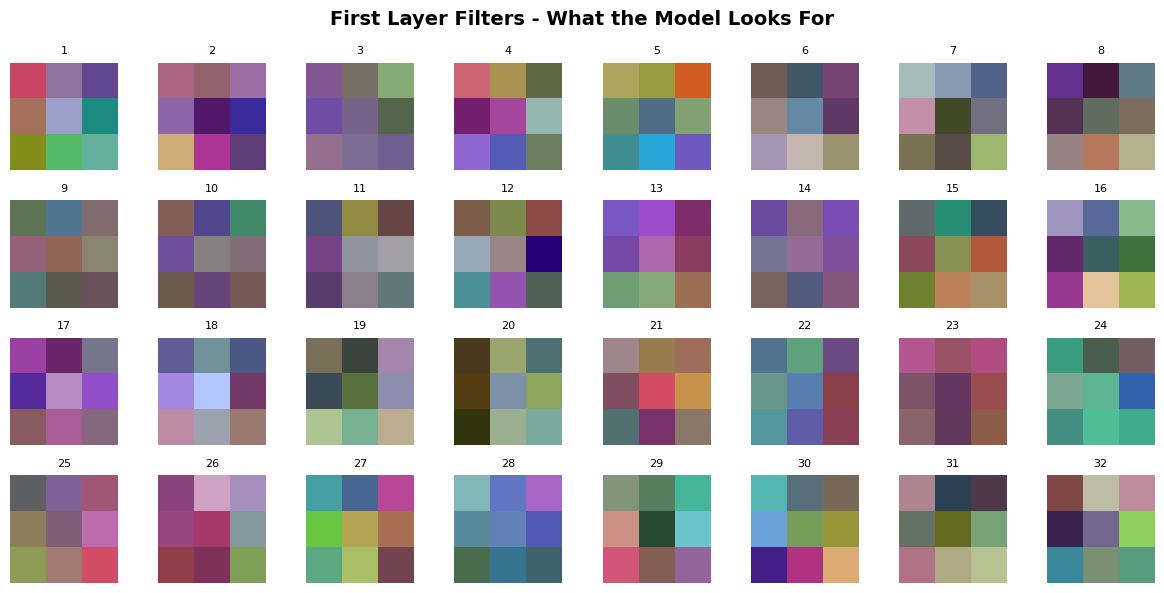

In [18]:
# Get first convolutional layer

# visualize first layer filters
first_conv = None
for layer in model.layers:
    if isinstance(layer, layers.Conv2D):
        first_conv = layer
        break

# Extract filters
filters, biases = first_conv.get_weights()
print(f"Filter shape: {filters.shape}")

# Normalize for visualization
f_min, f_max = filters.min(), filters.max()
filters_norm = (filters - f_min) / (f_max - f_min)

# Display first 32 filters
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.ravel()

for i in range(32):
    axes[i].imshow(filters_norm[:, :, :, i])
    axes[i].set_title(f'{i+1}', fontsize=8)
    axes[i].axis('off')

plt.suptitle('First Layer Filters - What the Model Looks For', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

These 32 filters reveal what the first layer picked up. Some detect edges at different angles, others pick up color patches or simple textures. The model learned on its own that edges matter. There was no instruction to look for them.

- Option C - Per-Class Analysis

     Class  Precision  Recall  F1-Score  Support
automobile   0.910680   0.938  0.924138     1000
      ship   0.911765   0.899  0.905337     1000
     truck   0.837421   0.922  0.877677     1000
     horse   0.870775   0.876  0.873380     1000
  airplane   0.855578   0.859  0.857285     1000
      bird   0.848000   0.742  0.791467     1000
      frog   0.668768   0.955  0.786656     1000
      deer   0.815931   0.758  0.785899     1000
       dog   0.845588   0.690  0.759912     1000
       cat   0.779394   0.643  0.704658     1000


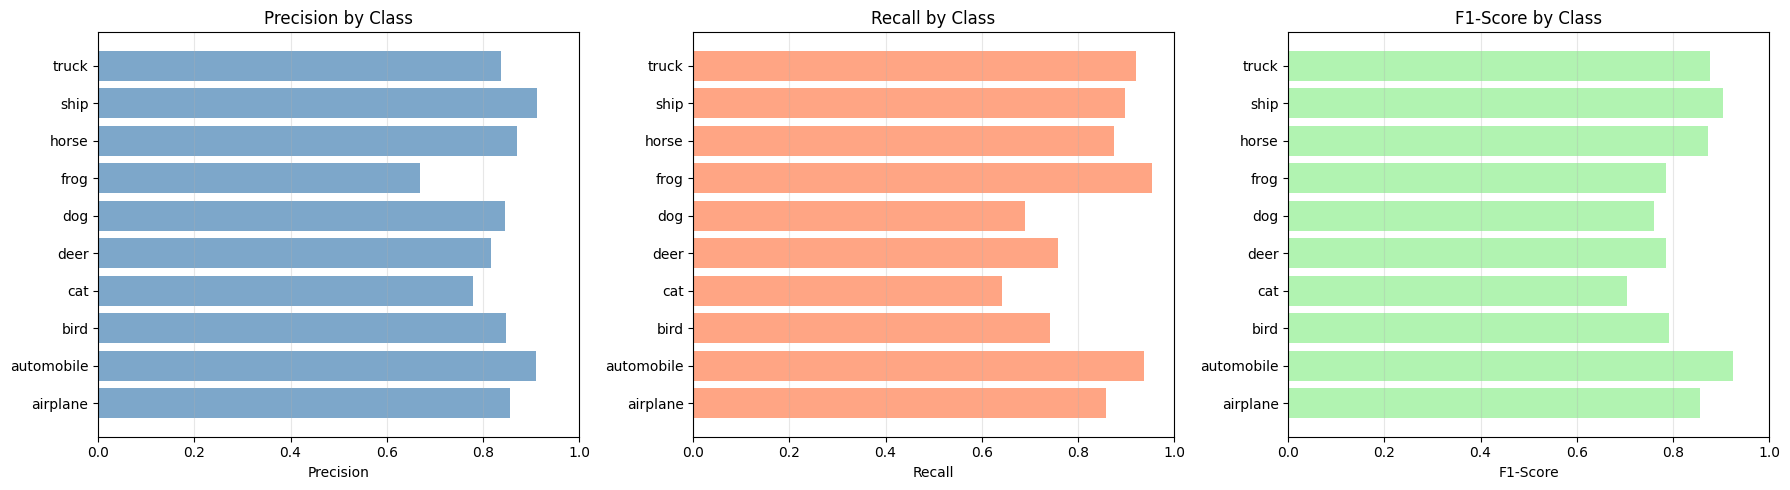

In [19]:
# YOUR CREATIVE EXTENSION

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

precision, recall, f1, support = precision_recall_fscore_support(
    y_test.flatten(), y_pred_classes, labels=range(10)
)

# Create DataFrame
class_metrics = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

class_metrics = class_metrics.sort_values('F1-Score', ascending=False)
print(class_metrics.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision
axes[0].barh(class_names, precision, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Precision')
axes[0].set_title('Precision by Class')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

# Recall
axes[1].barh(class_names, recall, color='coral', alpha=0.7)
axes[1].set_xlabel('Recall')
axes[1].set_title('Recall by Class')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

# F1-Score
axes[2].barh(class_names, f1, color='lightgreen', alpha=0.7)
axes[2].set_xlabel('F1-Score')
axes[2].set_title('F1-Score by Class')
axes[2].set_xlim(0, 1)
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


Best performing class: automobile
F1-Score: 0.924

Worst performing class: cat
F1-Score: 0.705


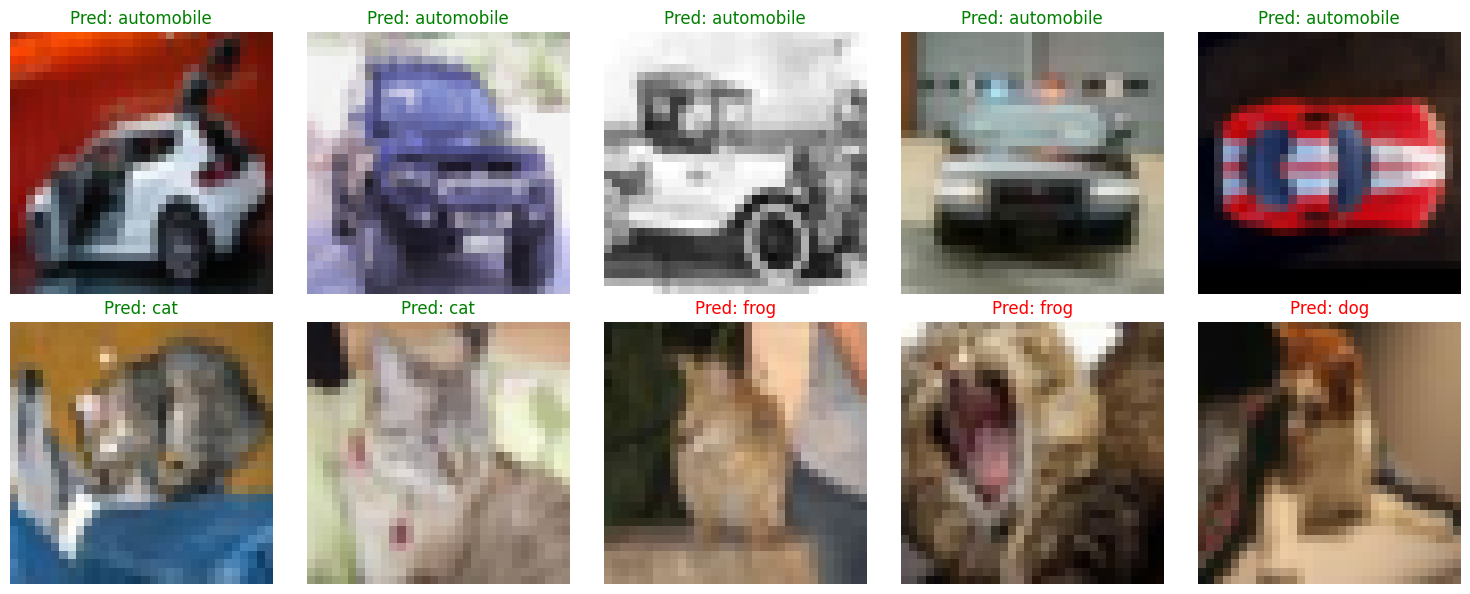

In [20]:
# Analyze best and worst performing classes
best_class = class_metrics.iloc[0]['Class']
worst_class = class_metrics.iloc[-1]['Class']

print(f"\nBest performing class: {best_class}")
print(f"F1-Score: {class_metrics.iloc[0]['F1-Score']:.3f}")
print(f"\nWorst performing class: {worst_class}")
print(f"F1-Score: {class_metrics.iloc[-1]['F1-Score']:.3f}")

# Show examples from best and worst classes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Best class examples
best_idx = np.where(y_test.flatten() == class_names.index(best_class))[0][:5]
for i, idx in enumerate(best_idx):
    axes[0, i].imshow(x_test[idx])
    pred_label = class_names[y_pred_classes[idx]]
    color = 'green' if y_pred_classes[idx] == y_test[idx][0] else 'red'
    axes[0, i].set_title(f'Pred: {pred_label}', color=color)
    axes[0, i].axis('off')

# Worst class examples  
worst_idx = np.where(y_test.flatten() == class_names.index(worst_class))[0][:5]
for i, idx in enumerate(worst_idx):
    axes[1, i].imshow(x_test[idx])
    pred_label = class_names[y_pred_classes[idx]]
    color = 'green' if y_pred_classes[idx] == y_test[idx][0] else 'red'
    axes[1, i].set_title(f'Pred: {pred_label}', color=color)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel(f'{best_class}\n(Best)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel(f'{worst_class}\n(Worst)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**EXPLANATION:**

Automobile comes out on top with 92.4% F1. Cars have simple, boxy shapes and visible wheels that are easy to recognize even in tiny images. Cats are the hardest, scoring 70.5% F1. They appear in many poses curled, stretched or seen from odd angles and at 32×32 pixels a brown curled cat can look just like a brown blob.

---

## Submission Checklist

- [ ] Test accuracy ≥ 75%
- [ ] Data augmentation implemented
- [ ] Architecture explained in detail
- [ ] LLM collaboration documented (4+ prompts)
- [ ] Error analysis completed
- [ ] Creative extension implemented

## Final Reflection

**YOUR REFLECTION:**

This assignment taught me far more about practical experience in deep learning. In real world, there is a huge difference between understanding concepts in theory and actually implementing them, dealing with real data and seeing how models behave in practice. The central lesson was that overfitting is the main challenge. Deciding on dropout rates, augmentation and the number of layers was all about finding the right balance enough capacity to learn real patterns without simply memorizing the training data. The difference was obvious the four-layer model overfit badly, hitting 88% on training but only 71% on validation, while the final three-layer model stayed balanced, with 83% on both training and validation and 82.82% on the test set.

Simple, standard techniques often matter more than clever tricks. Data augmentation, for example, was conceptually simple but had the single biggest impact, probably adding 15 or more percentage points to accuracy. It’s a reminder that the methods labeled 'basic' are often standard because they work. Understanding where a model fails can be more valuable than overall accuracy. Knowing that my model misclassified 13.4% of cats as frogs tells far more about its weaknesses than the 82.82% test score alone. Real world applications require knowing exactly where and why models make mistakes. Iteration and experimentation are essential. The first model reached 68%, the second overfit at 71% validation and only through repeated testing of architectures and hyperparameters did the model reach the sweet spot. The LLM helped by pointing toward proven practices but the actual improvement came from running experiments and analyzing results.

If starting over, few changes would save time. In context, 82.82% test accuracy puts this model solidly in the 'good CNN' range. Random guessing hits 10%, simple methods 40–50%, decent CNNs 65–75% and good CNNs 75–85%. This implementation not only met the 75% target but exceeded it by almost 8 points, built entirely from scratch on a CPU.

The skills learned carry over to other projects. Working with data, designing the network, handling overfitting, adjusting hyperparameters, analyzing mistakes and visualizing features are all useful in any computer vision task. The details might change ResNet instead of a simple CNN, or medical scans instead of tiny photos but the core ideas stay the same, give the model enough capacity, regularize to prevent memorization, use augmentation wisely and check results carefully. The 'frog problem' stood out the most. At 32×32 pixels, the model often labeled animals with green or brown backgrounds as frogs. It wasn’t making random mistakes, just following a pattern that appeared frequently in the training set. Figuring out why this happened was far more valuable than just looking at overall accuracy. 

In the end, building the model was far more educational than reading about it. Working through overfitting, tuning hyperparameters and investigating errors took time and effort, but it was extremely rewarding. Surpassing the 75% target made all of it feel worth it.

